# Clustering song data

I want to get the data on my current playlists and analyse it.

I had the idea because I was checking out older playlists that I don't remember the vibe of anymore, and they have over 12 hours so I can't listen to all of them. So I would like an overview of genres and vibes and if there are any outliers that don't fit there I can listen to them and see if they fit or not.

So I found this website that gives me a CSV of my playlist from spotify, with some scores on different metrics such as energy, happiness, etc. These will work well as numerical features. Encoding the genres and subgenres can also be interesting as an extra feature. 

Here I will do data sanitization and preprocessing, normalization of features, k-means clustering, and dimensionality reduction for vizualising the clusters.

I chose k-means clustering by looking at the effect of different clustering algorithms on data sets of different forms. It's hard to visualise the distribution of my dataset when it has 10 features, but i imagine it's probably some clusters that are quite interspersed with each other, maybe similar to the 3rd row in Figure 1. I imagine that the boundary between clusters for songs in the same playlist is quite thin or unclear.

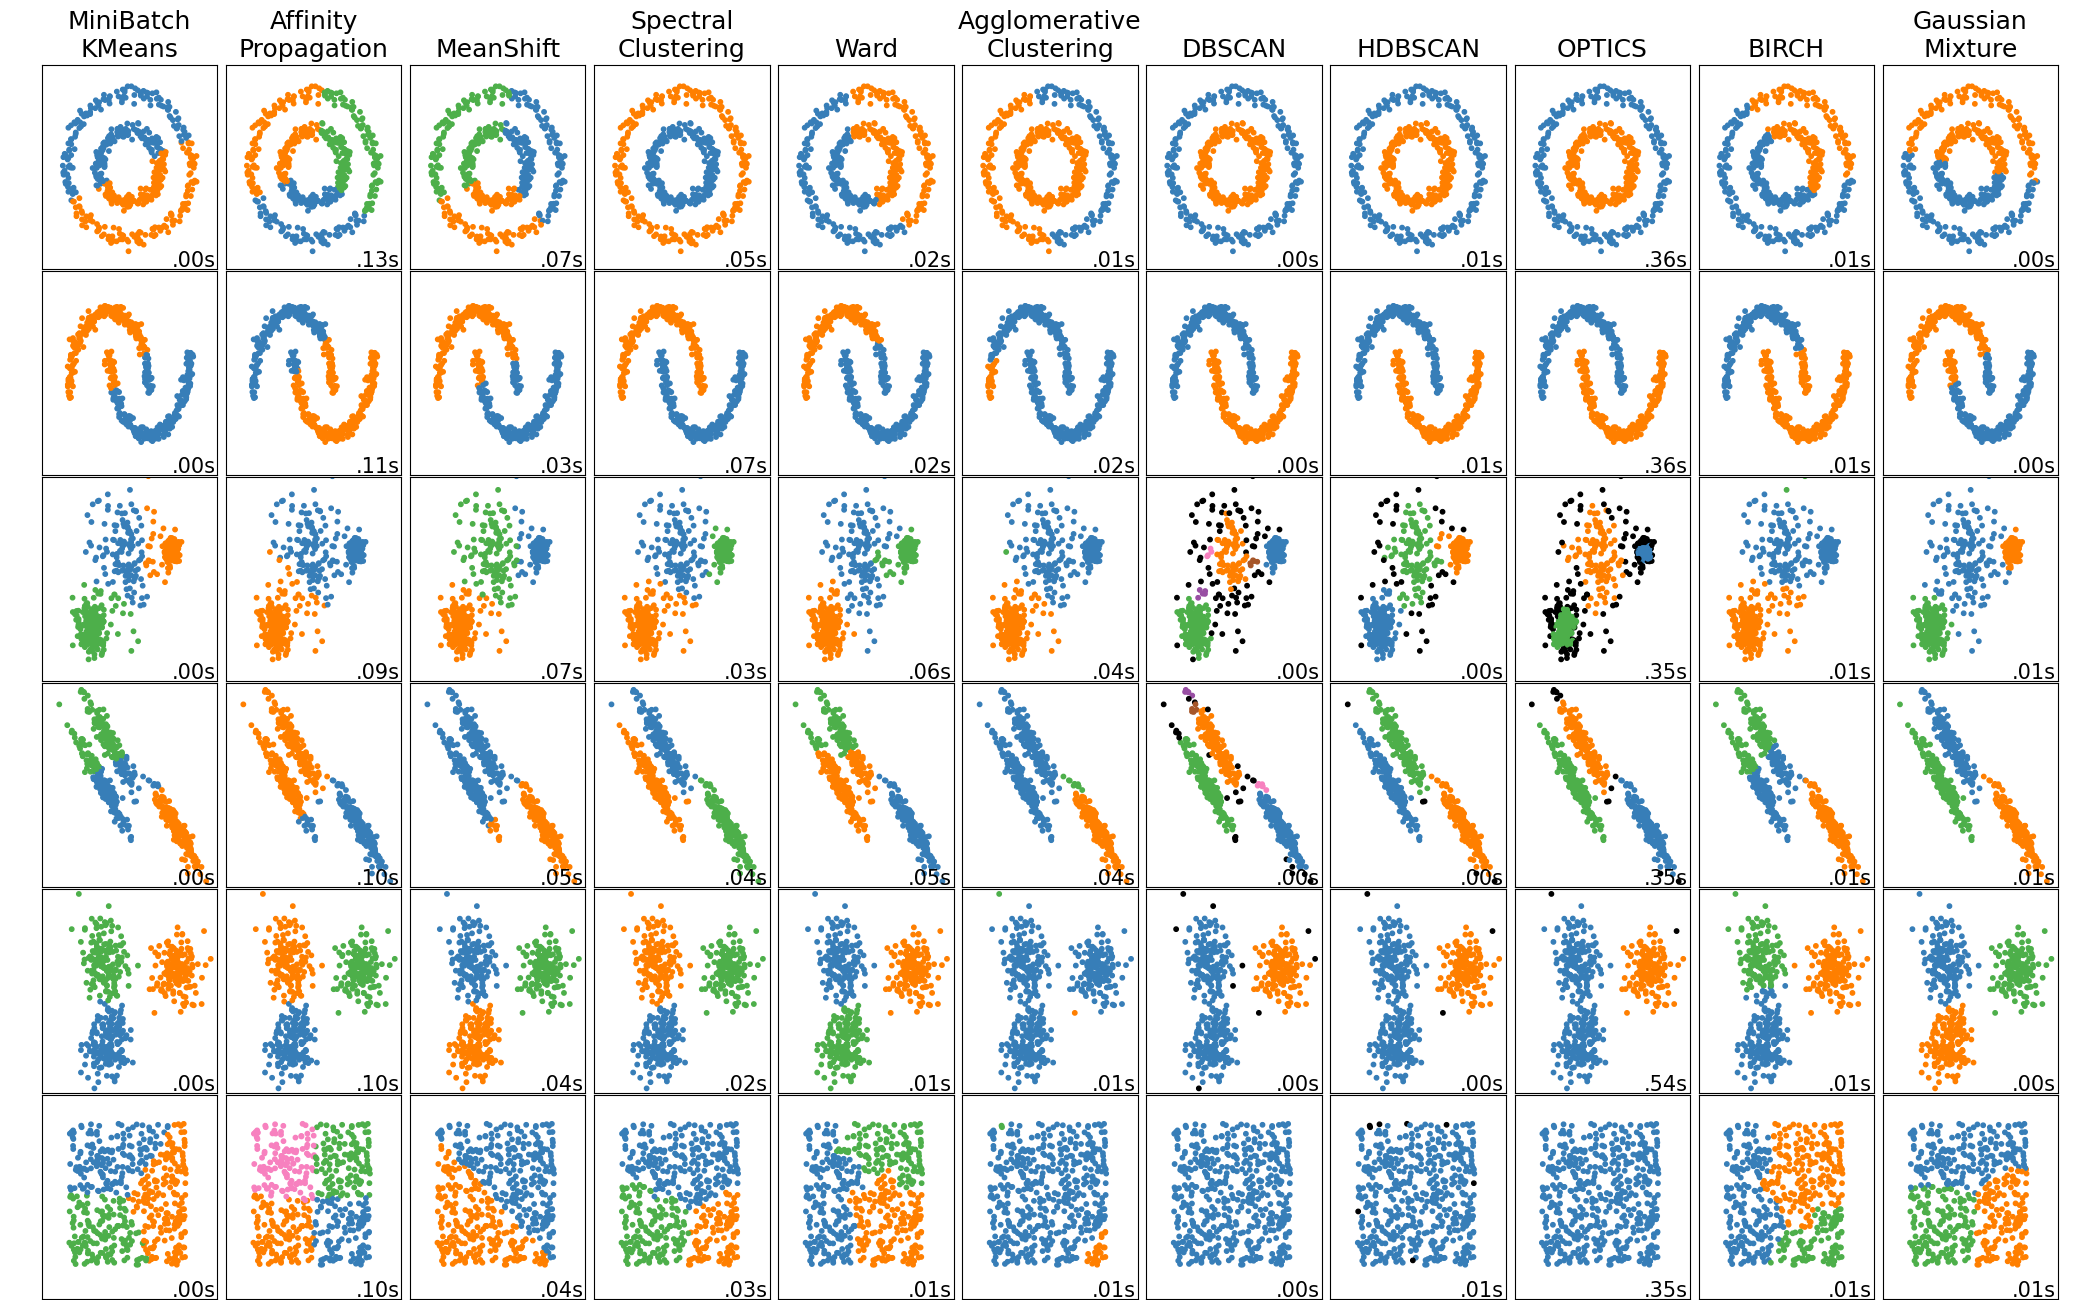
Figure 1: Comparison of different clustering methods on different dataset shapes/distribution, from Scikit documentation.

But k-means works for an even cluster size though, so it's not ideal for this dataset probably.

### Getting playlist data

I can download the data by inputting the link of my public Spotify playlist to https://www.chosic.com/spotify-playlist-analyzer/.

It will let me download a CSV with playlist data, which has some nice sentiment-related features. They are numerical features.

### Data sanitization

I open the CSV and delete the columns I don't need, merge the genres and the parent genres columns into one.

### Reading the data

I use the Pandas library to read the data from the CSV file into a Pandas dataframe.

- We wanna use utf-8 encoding because the Key column uses musical notation characters, eg. C♯ or D♭.

In [70]:
import pandas as pd

df = pd.read_csv('audioself.csv', delimiter=',', encoding='utf-8')

print('Data has the following columns: ')
for column in df.columns:
    print(f"{column}")

Data has the following columns: 
#
Song
Artist
Popularity
BPM
Genres
Parent Genres
Album
Album Date
Time
Dance
Energy
Acoustic
Instrumental
Happy
Speech
Live
Loud (Db)
Key
Time Signature
Added At
Spotify Track Id
Album Label
Camelot
ISRC



### Selecting the features

I pick a few columns of the dataframe object: numerical features that reflect a song's vibe.

I select only the columns with keys in the `features` array


In [71]:

features = ['BPM','Dance', 'Energy', 'Acoustic', 'Instrumental','Happy', 'Speech', 'Live', 'Loud (Db)']

X = df[features]

print(X)

    BPM  Dance  Energy  Acoustic  Instrumental  Happy  Speech  Live  Loud (Db)
0   125     61      60        37             0     37       0    10         -8
1   120     67      92         5             1     78       0     0         -4
2   107     47      79         0            37     47       0    20         -7
3   107     76      55        71             1     51       0    20         -8
4    75     36      50         6             0     32       0    10         -9
..  ...    ...     ...       ...           ...    ...     ...   ...        ...
88   96     45      25         4             7     37       0    40        -16
89  123     48      26        74             1     38       0    80        -16
90  148     55      93         0             0     37       0    30         -5
91  130     79      86        27             0     96       0    10         -4
92  180     33      65        51            16     21       0    10         -8

[93 rows x 9 columns]


### Normalizing the data

I preprocess the data by normalizing it. Normalized data is needed for K-Means.

I do this by scaling it to have a mean of 0 and standard deviation of 1. This prevents features with larger ranges from dominating the model.

In [72]:
### Handling missing genres data
df['Genres'] = df['Genres'].fillna('')

### Create genre diversity feature
df['genre_count'] = df['Genres'].apply(lambda x: len(x.split(', ')) if x else 0)

### Selecting the features
features = ['BPM','Dance', 'Energy', 'Acoustic', 'Instrumental','Happy', 'Speech', 'Live', 'Loud (Db)', 'genre_count']

X = df[features]

### Normalizing the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### K-means clustering

I use K-means to group songs into k=4 clusters based on their audio features and genre diversity. K-means works by iteratively assigning each song to the nearest cluster center and updating those centers until convergence. 

I chose k=4 clusters through experimentation—this seemed to give meaningful groupings without over-segmenting the playlist. Each cluster represents songs with similar vibes.

In [73]:

import numpy as np
from sklearn.cluster import KMeans

k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

grouped_by_clusters = df.groupby("Cluster")
grouped_by_clusters.sum()

from sklearn.metrics import silhouette_score
silhouette = silhouette_score(X_scaled, kmeans.labels_)

print('Silhouette score: ', silhouette)

for i in range(k):
    print(f'Cluster {i}: ')

    print(grouped_by_clusters['Song'].get_group(i).to_list())

    bpm_list = grouped_by_clusters['BPM'].get_group(i).to_list()
    avg_bpm = np.average(bpm_list)
    print(f'-- Average BPM: {avg_bpm.round(2)}')

    happiness_list = grouped_by_clusters['Happy'].get_group(i).to_list()
    avg_happiness = np.average(happiness_list)
    print(f'-- Average Happiness: {avg_happiness.round(2)}')

    energy_list = grouped_by_clusters['Energy'].get_group(i).to_list()
    avg_energy = np.average(energy_list)
    print(f'-- Average Energy: {avg_energy.round(2)}')

    loud_list = grouped_by_clusters['Loud (Db)'].get_group(i).to_list()
    avg_loud = np.average(loud_list)
    print(f'-- Average Loudness: {avg_energy.round(2)}')

    print('\n')

Silhouette score:  0.12855322374480038
Cluster 0: 
['Supermassive Black Hole', 'Biscuit Town', 'Pork Soda', 'Prophet', 'Fishies', 'Oblivion', 'Shivers', 'Fairly Local', 'Bandito', 'Make It Wit Chu', 'Blood // Water', 'Life Itself', 'Loving Is Easy (feat. Benny Sings)', 'Sunshine', 'Ascension (feat. Vince Staples)', 'Never in My Wildest Dreams', 'On Melancholy Hill', 'Take Me To Church', 'The Less I Know The Better', 'Doubt', 'There, There', 'Overcome', 'Get Free', 'Some Feeling', 'Lone Digger', 'Время ток', 'Rolling Stoner', 'Clint Eastwood', 'Killshot - Slowed + Reverb', "She's My Collar (feat. Kali Uchis)", 'HURT (feat. The Warning)', 'Two Shoes', 'Mercy']
-- Average BPM: 121.82
-- Average Happiness: 61.79
-- Average Energy: 68.36
-- Average Loudness: 68.36


Cluster 1: 
['The Pot', 'Knights of Cydonia', 'Feels Like We Only Go Backwards', 'Char', 'B.Y.O.B.', 'Chop Suey!', 'Toxicity', 'My Own Summer (Shove It)', 'Flying Whales', 'Seasons In The Abyss', 'East Shore: In Our Deaf Lands',

### Visualising the clusters

I will plot the clusters, applying 2 methods for dimensionality reduction, PCA and T-SNE. T-SNE will likely show more interesting cluster separation since it's better at preserving local structure.

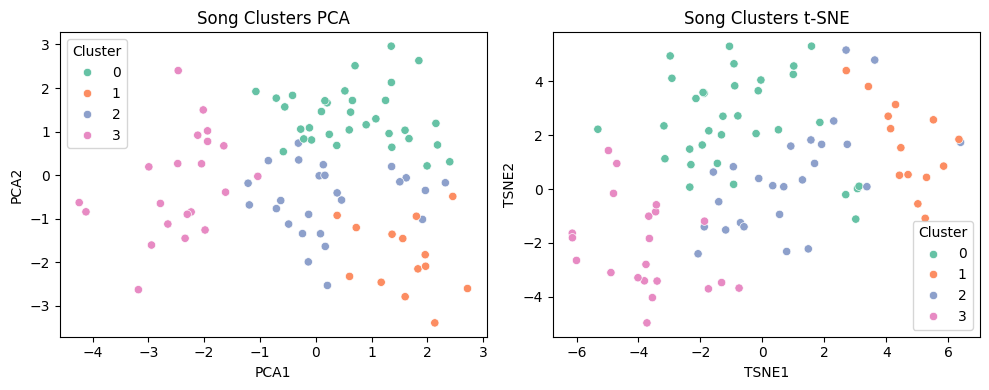

In [74]:

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot 1: PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]


sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Cluster', palette='Set2', ax=axes[0])
axes[0].set_title('Song Clusters PCA')

# Plot 2: T-SNE
from sklearn.manifold import TSNE
X_tsne = TSNE(n_components=2, perplexity=30, init='pca', random_state=42).fit_transform(X_full_dense)

df['TSNE1'] = X_tsne[:, 0]
df['TSNE2'] = X_tsne[:, 1]

sns.scatterplot(data=df, x='TSNE1', y='TSNE2', hue='Cluster', palette='Set2', ax=axes[1])
axes[1].set_title('Song Clusters t-SNE')

plt.tight_layout()
plt.show()